# Clustering using Gaussian Mixture Models
In this notebook, we will learn about mixture models that find applications can be used for clustering. To start with, we will focus on two clusters and we will use the expectation-maximisation algorithm for optimisation.

We will again work with the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data), which you first need to download and then load in this notebook. If you faced difficulties downloading this data set from Kaggle, you should download the file directly from Blackboard. The data set contains various aspects of cell nuclei of breast screening images of patients with _(malignant)_ and without _(benign)_ breast cancer. Our goal is to cluster the data without without the knowledge of the tumor being malignant or benign.



In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 

<a name="section-1"></a>

## Section 1: Gaussian Mixture Model

We start with the definition of a Gaussian Mixture Model (GMM):
$$
P(\boldsymbol{X}=\boldsymbol{x}) = \sum_{k=1}^K \pi_k p_k(\boldsymbol{x}|\boldsymbol{\theta})\, .
$$
Here $K$ is the number of clusters described as mixture components, each of which are multivariate normal distributions:
$$
p_k(\boldsymbol{x}|\boldsymbol{\theta}) = {\displaystyle (2\pi )^{-k/2}\det({\boldsymbol {\Sigma }_k})^{-1/2}\,\exp \left(-{\frac {1}{2}}(\mathbf {x} -{\boldsymbol {\mu }_k})^{\!{\mathsf {T}}}{\boldsymbol {\Sigma }_k}^{-1}(\mathbf {x} -{\boldsymbol {\mu }_k})\right),}
$$
where $\boldsymbol{\theta} = \{\pi_k,\mu_k, \Sigma_k \}_{k=1,2,...,K}$ is the vectors of parameters consiting of the mixture weight $\pi_k$, mixture component mean $\boldsymbol{\mu}_k$ and mixture component covariance matrix $\boldsymbol{\mu}_k$.

In [2]:
class GMModel:
    """Struct to define Gaussian Mixture Model"""
    """:param dim: number of mixture components"""
    """:param weights: mixture weights"""
    """:param mu: mixture component means for each cluster"""
    """:param sigma: mixture component covariance matrix for each cluster"""
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 


We can perform 'soft' clustering of the data using the cluster probabilities of the data:
$$r_{ik}(\boldsymbol{\theta})=P(Z=k|\boldsymbol{X}=\boldsymbol{x}_i,\boldsymbol{\theta}) = \frac{\pi_k p_k(\boldsymbol{x}_i|\boldsymbol{\theta})}{\sum_{k'=1}^K \pi_{k'} p_{k'}(\boldsymbol{x}_i|\boldsymbol{\theta})}$$
This denotes the probability of data point $i$ to belong to cluster $k$. Generally, this yields a distribution over each data point.

In [3]:
## EDIT THIS FUNCTION
def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) ### <- fill in
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights

For visualisation it is useful to present the results as hard clusters on the output through the argmax of the cluster distribution:

In [4]:
## EDIT THIS FUNCTION
def predict(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1) ### <- fill in MAP estimate

Let us initialise try the HMM clustering by generating some synthetic data. Sampling Gaussian mixtures is relatively straightforward. 

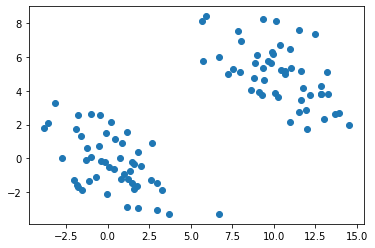

In [5]:
np.random.seed(42)
def testdata():
    cov = np.array([[6, -3], [-3, 3.5]])
    A = np.random.multivariate_normal([0, 0], cov, size=50)
    B = np.random.multivariate_normal([10, 5], cov, size=50)
    return np.vstack((A,B)) # combine

data0=testdata()
plt.scatter(data0[:,0],data0[:,1])
plt.show()

We borrow some plot functions from the *Python Data Science Handbook* to visualise the mixture model.

See https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [6]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = predict(gmm,X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights.max()
    for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.phi):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    return ax

We can now cluster the synthetic data using randomly generated mixture model:

<AxesSubplot:>

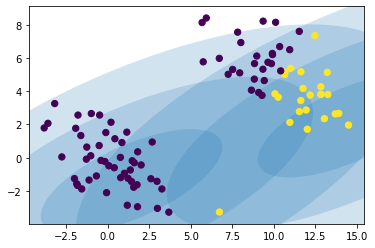

In [7]:
np.random.seed(4)
gmm = GMModel(data0,2)
plot_gmm(gmm,data0)

<a name="section-3"></a>

## Section 2: Fitting Gaussian Mixture Models using the EM algorithm

We employ the EM algorithm to fit the data. The algorithm iteratively updates parameters of the Gausian Mixture. The algorithm is guarantees to improve (or at least not worsen) the marginal likelihood of the data. The algorithm updates the mixture weights:
$$
	\pi_k^{(n+1)} = \frac{1}{N}\sum_{i=1}^N r_{ik}(\boldsymbol{\theta}^{(n)}),
$$
and computes the cluster means using a weighted mean:
$$	\boldsymbol{\mu}_k^{(n+1)} =\sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(n)}) \boldsymbol{x}_i$$
and similarly for the covariances according to
$$\boldsymbol{\Sigma}_k^{(n+1)}= \sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(n)}) (\boldsymbol{x}_i-\boldsymbol{\mu}_k) (\boldsymbol{x}_i-\boldsymbol{\mu}_k)^T.$$
The weights are obtained from the cluster probabilities via
$$w_{ik}(\boldsymbol{\theta}^{(n)})=\frac{r_{ik}(\boldsymbol{\theta}^{(n)})}{\sum_{i'} r_{i'k}(\boldsymbol{\theta}^{(n)})}$$
One step in this iteration can be implemented in the function:

In [8]:
## EDIT THIS FUNCTION
def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X) ### <- fill in
    gmm.phi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True) ### <- fill in

One EM iteration does not significantly improve the result:

<AxesSubplot:>

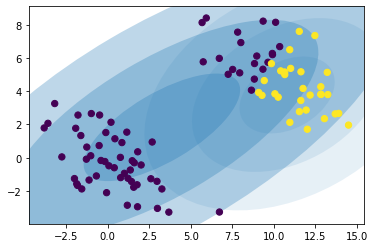

In [9]:
fitStep(gmm,data0)
plot_gmm(gmm,data0)

Let's see if we can observe some improvement after several iterations:

<AxesSubplot:>

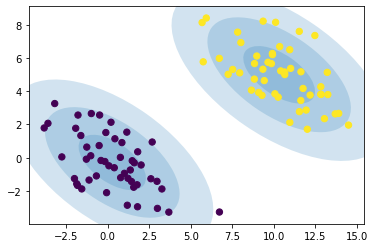

In [10]:
for _ in range(10):
    fitStep(gmm,data0)
plot_gmm(gmm,data0)

<a name="section-3"></a>

## Section 3:  Clustering of breast cancer data

If you run this notebook locally on your machine, you will simply need to place the `csv` file in the same directory as this notebook.
If you run this notebook on Google Colab, you will need to use

  `from google.colab import files`

  `upload = files.upload()`

and then upload it from your local downloads directory. The following code reproduces a plot from 

(569, 33)


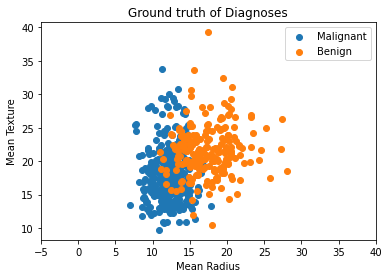

In [11]:
#from google.colab import files
#upload = files.upload()
data = pd.read_csv('./data.csv')

# print shape and last 10 rows
print(data.shape)
data.tail(10)

# drop last column (extra column added by pd)
data_1 = data.drop(data.columns[-1], axis=1)
# set column id as dataframe index
data_2 = data_1.set_index(data['id']).drop(data_1.columns[0], axis=1)

# convert categorical labels to numbers
diag_map = {'M': 1.0, 'B': -1.0}
data_2['diagnosis'] = data_2['diagnosis'].map(diag_map)

# put labels and features in different dataframes
y = data_2.loc[:, 'diagnosis']
X = data_2.iloc[:, 1:]

labels = ["Malignant", "Benign"]
for i, c in enumerate(np.unique(y)):
    plt.scatter(data_2.iloc[:, 1][y==c],data_2.iloc[:, 2][y==c],label=labels[i]);
plt.xlabel("Mean Radius");
plt.ylabel("Mean Texture");
plt.title("Ground truth of Diagnoses");
plt.xlim([-5,40])
plt.legend();

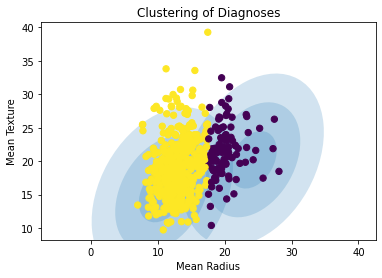

In [12]:
X=np.array([data_2.iloc[:, 1],data_2.iloc[:, 2]]).T
np.random.seed(4)
gmm2 = GMModel(X,2)
plot_gmm(gmm2,X)
plt.xlabel("Mean Radius");
plt.ylabel("Mean Texture");
plt.title("Clustering of Diagnoses");

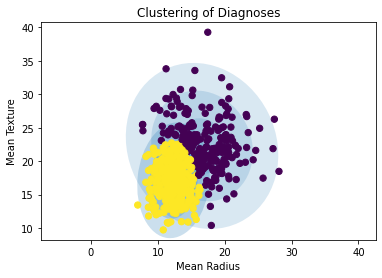

In [13]:
for _ in range(100):
    fitStep(gmm2,X)
plot_gmm(gmm2,X)
plt.xlabel("Mean Radius");
plt.ylabel("Mean Texture");
plt.title("Clustering of Diagnoses");

/tmp/ipykernel_213966/3484243919.py:15: RuntimeWarning: invalid value encountered in sqrt
  width, height = 2 * np.sqrt(covariance)


ValueError: too many values to unpack (expected 2)

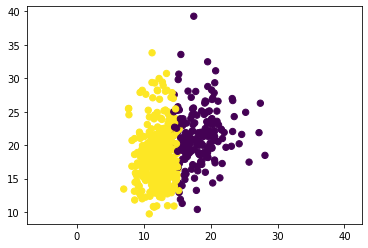

In [14]:
X=np.array([data_2.iloc[:, i] for i in range(1,6)]).T
np.random.seed(4)
gmm3 = GMModel(X,2)
for _ in range(100):
    fitStep(gmm3,X)
plot_gmm(gmm3,X)
plt.xlabel("Mean Radius");
plt.ylabel("Mean Texture");
plt.title("Clustering of Diagnoses");

**Questions:**

* How do know that the EM algorithm converged? 
* How could the clustering of the cancer data set be improved?
* Can you quantify the uncertainty of cluster assignments for the cancer data set?
* Can you think of caveats when optimising hyperparameters of GMMs? 
* What are suitable criteria for clustering quality using mixture models? 